In [5]:
import csv
import numpy as np
from collections import defaultdict
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import networkx.algorithms.community as nx_comm
from itertools import combinations
from scipy import stats
from scipy.stats import iqr
from scipy.stats import skewtest
from scipy.stats import skew
from scipy.stats import kurtosistest
from scipy.stats import kurtosis
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.patches as mpatches
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import statistics









In [6]:
# read in graphs
papers = ['Baghizadeh2020', 'D_Arcy2011', 'Günther2017','Moeini2019', 
          'Oehlhorn2020', 'Peireira2020', 'Piccoli2005', 'Schneider2014',
          'Siponen2004', 'Jiang2021', 'Teubner2020', 'Tsai2017',
          'Wiener2020', 'Xiao2013']

# appends the metrics for each graph of each review to a pandas dataframe table which is analyzed later 

whole_table = []
for name in papers:
    print(name + ' - loading')
    dc_graph = nx.read_gexf("./graphs/" + name + "_dc.gexf")
    bc_graph = nx.read_gexf("./graphs/" + name + "_bc.gexf")
    
    # general
    
    # list of all nodes
    all_nodes = list(dc_graph.nodes)
    
    # number of all_nodes
    n_all_nodes = dc_graph.number_of_nodes()

    # list of core publications
    core_nodes = []
    for node in all_nodes:
        if dc_graph.out_degree(node) > 0:
            core_nodes.append(node)
            
    # number of core publications
    n_core_nodes = len(core_nodes)
    
    # core nodes time iqr
    publication_year_core_nodes = []
    for core_node in core_nodes:
        core_node_year = int(core_node[-4:])
        publication_year_core_nodes.append(core_node_year)
    iqr_years_core_nodes = iqr(publication_year_core_nodes)
    skewness_years = skew(publication_year_core_nodes)

    # average core paper references
    references_core_papers = list(j for i, j in dc_graph.out_degree(core_nodes))
    mean_references_core_papers = np.mean(references_core_papers)

    # graph metrics

    # core paper density
    dc_core_node_graph = nx.subgraph(dc_graph, core_nodes)
    dc_core_node_density = nx.density(dc_core_node_graph) * 2

    # avg citation overlap according to the pptx from Prof. Dr. Teubner
    def convert_tuple (tuple_list):
        converted_list = []
        for x,y in tuple_list:
            converted_list.append(y)
        return converted_list
    
    share_sum = 0
    for key_1,key_2 in combinations(core_nodes,2):
        if key_1 == key_2:
            continue
        key_1_references = len(list(dc_graph.edges([key_1])))
        key_2_references = len(list(dc_graph.edges([key_2])))
        key_1_list = convert_tuple(dc_graph.edges([key_1]))
        key_2_list = convert_tuple(dc_graph.edges([key_2]))
        shared_references = len([x for x in key_1_list if x in key_2_list])
        total_references = key_1_references + key_2_references - shared_references
        share_sum += shared_references / total_references
    dc_average_citation_overlap = share_sum * (2/(len(core_nodes)*(len(core_nodes)-1)))
    
    # number of connected components
    subgraph_components = list(nx.connected_components(dc_graph.to_undirected()))
    largest_component_node_list = max(subgraph_components, key=len)
    unconnected_nodes = []
    for component in subgraph_components:
        if len(component) < len(largest_component_node_list) :
            for node in component:
                unconnected_nodes.append(node)
    
    dc_number_of_components = len(subgraph_components)

    # number of unconnected core publications
    dc_number_unconnected_core_nodes = len([x for x in core_nodes if x in unconnected_nodes])

    # bibliographic coupling section
    
    # number of nodes
    bc_nodes = bc_graph.number_of_nodes()
    
    # density
    bc_density = nx.density(bc_graph)
    
    # For Schneider2014 and Xiaxiao2013, 2 nodes are not connected
    # these 2 nodes are ignored for the diameter, avg-path length
    bc_number_of_components = nx.number_connected_components(bc_graph)
    if bc_number_of_components > 1:
        print(name + '- bc graph not fully connected')
        subgraph_components = list(nx.connected_components(bc_graph))
        largest_component_node_list = max(subgraph_components, key=len)
        bc_graph = bc_graph.subgraph(largest_component_node_list)
    
    
    # average shortest path
    bc_average_shortest_path = nx.average_shortest_path_length(bc_graph)
    
    # diameter
    bc_diameter = nx.diameter(bc_graph)
    
    
    
    whole_table.append([n_core_nodes, iqr_years_core_nodes, mean_references_core_papers, dc_average_citation_overlap, dc_core_node_density, dc_number_unconnected_core_nodes,
                        n_all_nodes, dc_number_of_components, bc_nodes, bc_density, bc_average_shortest_path, skewness_years])
    

Baghizadeh2020 - loading
D_Arcy2011 - loading
Günther2017 - loading
Moeini2019 - loading
Oehlhorn2020 - loading
Peireira2020 - loading
Piccoli2005 - loading
Schneider2014 - loading
Schneider2014- bc graph not fully connected
Siponen2004 - loading
Jiang2021 - loading
Teubner2020 - loading
Tsai2017 - loading
Wiener2020 - loading
Xiao2013 - loading
Xiao2013- bc graph not fully connected


In [7]:
df = pd.DataFrame(whole_table, columns = [
                                            'Core Publications', 'IQR Core Publication Years', 'Average Core Publication References',
                                            'Average Citation Overlap', 'Core Density' , 'Unconnected Core Publications',
                                            'DC Nodes', 'DC Components', 'BC Nodes',
                                            'BC Density', 'BC Average Shortest Path', 'Skewness Years'
                                        ], index = papers)


# adding clustering values manually from the gephi computations in the extracted PDF files
bc_modularity = [0.429, 0.237, 0.266, 0.334, 0.250, 0.504, 0.253, 0.257, 0.125, 0.274, 0.224, 0.155, 0.336, 0.435]
bc_n_cluster = [5, 3, 6, 7, 5, 10, 6, 5, 3, 5, 5, 4, 6, 6]
dc_modularity = [0.809, 0.706, 0.773, 0.673, 0.680, 0.878, 0.737, 0.694, 0.718, 0.610, 0.668, 0.624, 0.881, 0.912] 
dc_n_cluster = [32, 11, 28, 20, 25, 43, 22, 26, 13, 22, 16, 20, 33, 33]

df.insert(8, 'DC Modularity', dc_modularity)
df.insert(9, 'DC Clusters', dc_n_cluster)
df.insert(14, 'BC Modularity', bc_modularity)
df.insert(15, 'BC Clusters', bc_n_cluster)

# print and round all
df = df.round(decimals=pd.Series([0, 2, 1, 3, 3, 0, 0, 0, 3, 0, 0, 3, 2, 2, 3,2], index=df.columns))
df.round(5)


,Core Publications,IQR Core Publication Years,Average Core Publication References,Average Citation Overlap,Core Density,Unconnected Core Publications,DC Nodes,DC Components,DC Modularity,DC Clusters,BC Nodes,BC Density,BC Average Shortest Path,Skewness Years,BC Modularity,BC Clusters
Baghizadeh2020,92,8.25,46.3,0.007,0.039,1,3317,2,0.809,32,89,0.253,1.88,-0.78,0.429,5
D_Arcy2011,15,5.50,45.2,0.026,0.267,1,536,2,0.706,11,14,0.791,1.23,-1.18,0.237,3
Günther2017,67,1.00,42.4,0.011,0.015,2,2248,3,0.773,28,65,0.464,1.60,-0.15,0.266,6
Moeini2019,75,10.00,31.0,0.025,0.114,1,1462,2,0.673,20,74,0.489,1.56,0.20,0.334,7
Oehlhorn2020,70,14.00,45.2,0.014,0.094,3,2143,4,0.680,25,66,0.541,1.46,-0.05,0.250,5
Peireira2020,107,6.50,28.9,0.004,0.011,12,2697,13,0.878,43,93,0.169,2.17,-0.49,0.504,10
Piccoli2005,56,10.00,39.2,0.014,0.053,2,1673,3,0.737,22,54,0.461,1.57,-0.35,0.253,6
Schneider2014,88,9.00,37.6,0.011,0.060,1,2281,2,0.694,26,87,0.392,1.63,-0.53,0.257,5
Siponen2004,20,7.25,20.4,0.017,0.111,2,332,3,0.718,13,17,0.456,1.61,-0.27,0.125,3
Jiang2021,131,7.00,39.4,0.025,0.115,0,2957,1,0.610,22,131,0.697,1.31,-0.21,0.274,5


In [8]:
# create seperated metric per review tables from whole df
df_all_columns = df.columns

df_core_columns = df_all_columns[:6]
df_direct_citation_columns = df_all_columns[6:11]
df_bibliographic_coupling_columns = df_all_columns[11:17]

df_core = df.loc[:, df_core_columns]
df_direct_citation = df.loc[:, df_direct_citation_columns]
df_bib_coupling = df.loc[:, df_bibliographic_coupling_columns]


In [9]:
# print to latex
print(df_core.to_latex(index=True))
print(df_direct_citation.to_latex(index=True))
print(df_bib_coupling.to_latex(index=True))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Core Publications &  IQR Core Publication Years &  Average Core Publication References &  Average Citation Overlap &  Core Density &  Unconnected Core Publications \\
\midrule
Baghizadeh2020 &  92 &  8.25 &  46.3 &  0.007 &  0.039 &  1 \\
D\_Arcy2011     &  15 &  5.50 &  45.2 &  0.026 &  0.267 &  1 \\
Günther2017    &  67 &  1.00 &  42.4 &  0.011 &  0.015 &  2 \\
Moeini2019     &  75 &  10.00 &  31.0 &  0.025 &  0.114 &  1 \\
Oehlhorn2020   &  70 &  14.00 &  45.2 &  0.014 &  0.094 &  3 \\
Peireira2020   &  107 &  6.50 &  28.9 &  0.004 &  0.011 &  12 \\
Piccoli2005    &  56 &  10.00 &  39.2 &  0.014 &  0.053 &  2 \\
Schneider2014  &  88 &  9.00 &  37.6 &  0.011 &  0.060 &  1 \\
Siponen2004    &  20 &  7.25 &  20.4 &  0.017 &  0.111 &  2 \\
Jiang2021      &  131 &  7.00 &  39.4 &  0.025 &  0.115 &  0 \\
Teubner2020    &  33 &  4.00 &  65.1 &  0.029 &  0.080 &  0 \\
Tsai2017       &  49 &  6.00 &  43.2 &  0.045 &  0.159 &  0 \\
Wiener2020     &  55 

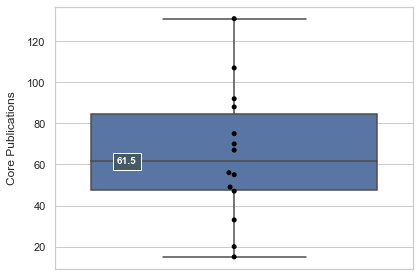

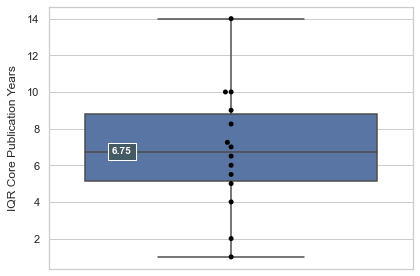

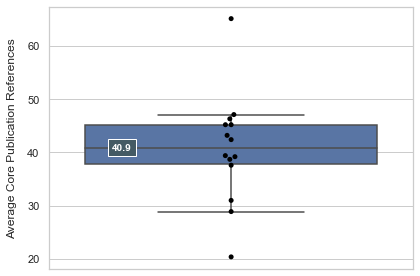

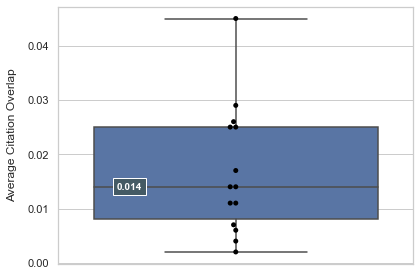

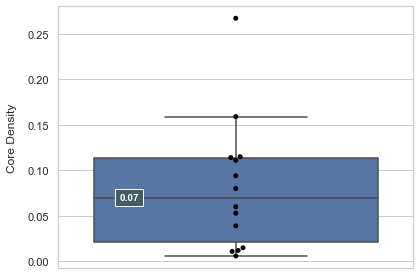

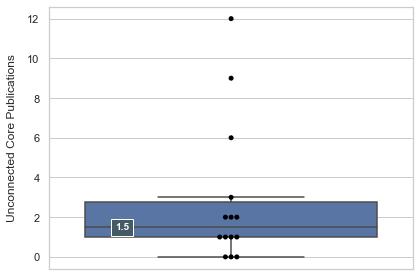

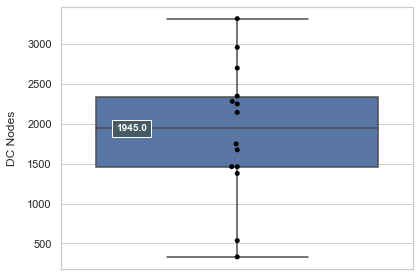

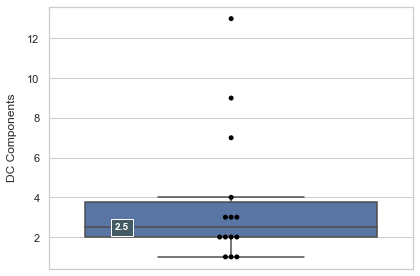

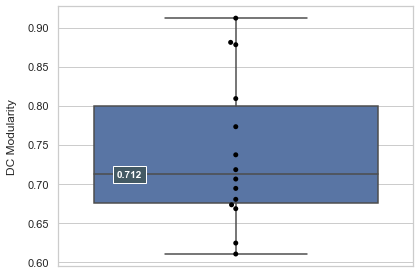

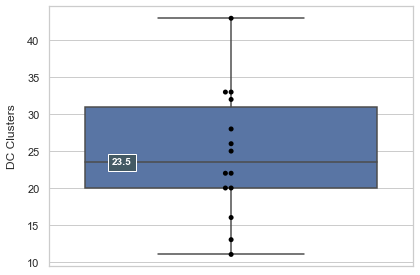

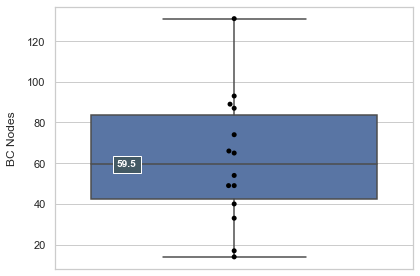

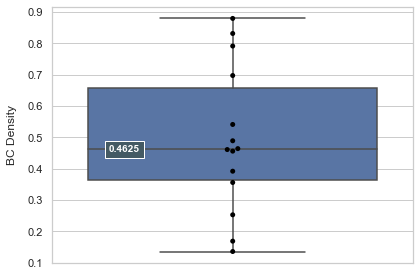

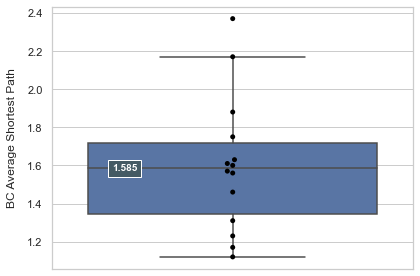

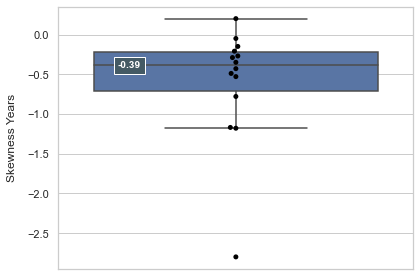

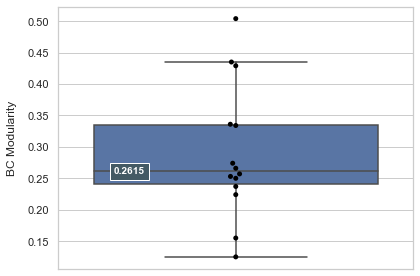

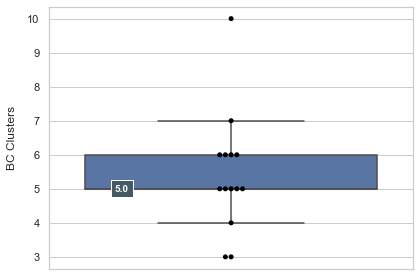

In [10]:
# create boxplots for each metric
# https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value
sns.set_theme(style="whitegrid")
df_metric_columns =  np.append([df.columns[0]], df.columns[1:17])

for column in df_metric_columns:
    box_plot = sns.boxplot(y=df[column].values, showfliers = False);
    sns.swarmplot(y=df[column].values, color="black")
    median = np.median(df[column].values)
    ax = box_plot.axes
    for xtick in box_plot.get_xticks():
        box_plot.text(
            -0.3, 
            median, 
            f'{median}', 
            ha='center', 
            va='center', 
            fontweight='bold',
            size=10,
            color='white',
            bbox=dict(facecolor='#445A64'))
    plt.ylabel(column, labelpad=10)
    plt.tight_layout()
    plt.savefig('boxsplots/' + column + '.pdf')  
    plt.show()

    
    
    

In [11]:
# compute and collect all statistical measures

# non-normality central tendency and variance
df_statistics = pd.DataFrame(columns = ["Min", "Max", "Median", "Confidence Interval Median 0.9426", "IQR", "Coefficient of Quartile Variation"])
for column in df_metric_columns:
    median = np.median(df[column].values)
    min_val = min(df[column].values)
    max_val = max(df[column].values)
    iqr_val = iqr(df[column].values)
    
    #https://cran.r-project.org/web/packages/cvcqv/vignettes/cqv_versatile.html
    iqr_val_coefficient = ((np.quantile(df[column].values, 0.75) - (np.quantile(df[column].values, 0.25)))/(np.quantile(df[column].values, 0.75) + (np.quantile(df[column].values, 0.25))))
    
    #https://online.stat.psu.edu/stat415/book/export/html/835
    conf_int = "(" + str(sorted(df[column].values)[4]) + ", " + str(sorted(df[column].values)[11]) + ")"
    
    df_statistics.loc[column] = min_val, max_val, median, conf_int, iqr_val, iqr_val_coefficient

df_statistics = df_statistics.round(4)

df_statistics_core = df_statistics.iloc[0:6, :]
df_statistics_direct_citation = df_statistics.iloc[6:10, :]
df_statistics_bib_coupling = df_statistics.iloc[10:17, :]

# to latex
print(df_statistics_core.to_latex(index=True))
print(df_statistics_direct_citation.to_latex(index=True))
print(df_statistics_bib_coupling.to_latex(index=True))

# normality central tendency, variance and skew
df_normal_statistics = pd.DataFrame(columns = ["Mean", "Standard Deviation", "Fisher-Pearson Coefficient of Skewness"])
print(df_metric_columns)
for column in df_metric_columns:
    mean = np.mean(df[column].values)
    standard_deviation = np.std(df[column].values)
    df_normal_statistics.loc[column] = mean, standard_deviation, skew(df[column].values)
    
df_normal_statistics = df_normal_statistics.round(3)

df_normal_statistics_core = df_normal_statistics.iloc[0:6, :]
df_normal_statistics_direct_citation = df_normal_statistics.iloc[6:10, :]
df_normal_statistics_bib_coupling = df_normal_statistics.iloc[10:17, :]

# to latex
print(df_normal_statistics_core.to_latex(index=True))
print(df_normal_statistics_direct_citation.to_latex(index=True))
print(df_normal_statistics_bib_coupling.to_latex(index=True))

\begin{tabular}{lllrlrr}
\toprule
{} &    Min &    Max &  Median & Confidence Interval Median 0.9426 &      IQR &  Coefficient of Quartile Variation \\
\midrule
Core Publications                   &  15 &  131 &  61.500 &  (49, 92) &  37.2500 &  0.2817 \\
IQR Core Publication Years          &  1.0 &  14.0 &  6.750 &  (5.5, 10.0) &  3.6875 &  0.2646 \\
Average Core Publication References &  20.4 &  65.1 &  40.900 &  (38.7, 46.3) &  7.3250 &  0.0882 \\
Average Citation Overlap            &  0.002 &  0.045 &  0.014 &  (0.011, 0.026) &  0.0170 &  0.5152 \\
Core Density                        &  0.006 &  0.267 &  0.070 &  (0.039, 0.115) &  0.0922 &  0.6872 \\
Unconnected Core Publications       &  0 &  12 &  1.500 &  (1, 6) &  1.7500 &  0.4667 \\
\bottomrule
\end{tabular}

\begin{tabular}{lllrlrr}
\toprule
{} &   Min &    Max &    Median & Confidence Interval Median 0.9426 &       IQR &  Coefficient of Quartile Variation \\
\midrule
DC Nodes      &  332 &  3317 &  1945.000 &  (1462, 2697) &

In [12]:
# all correlation scatter plots

SpearmanrResult(correlation=-0.221978021978022, pvalue=0.44562965795360865)

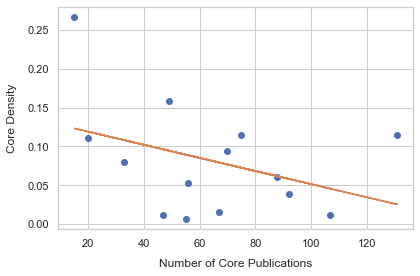

In [13]:
# core publications - core density
x = df['Core Publications']
y = df['Core Density']
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.xlabel("Number of Core Publications", labelpad=10)
plt.ylabel("Core Density", labelpad=10)
plt.plot(x, m*x + b)
plt.tight_layout()
plt.savefig('correlation/1.pdf') 
spearmanr(x,y)

SpearmanrResult(correlation=-0.335172726498658, pvalue=0.24141647084772797)

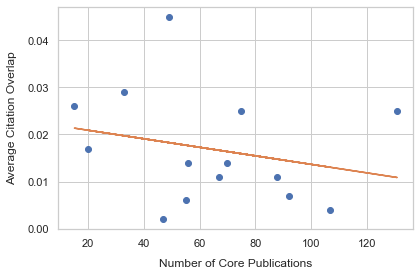

In [14]:
# core publications - average citation overlap
x = df['Core Publications']
y = df['Average Citation Overlap']
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.xlabel("Number of Core Publications", labelpad=10)
plt.ylabel("Average Citation Overlap", labelpad=10)
plt.plot(x, m*x + b)
plt.tight_layout()
plt.savefig('correlation/2.pdf')
spearmanr(x,y)

SpearmanrResult(correlation=0.2992301040627792, pvalue=0.29866966362857994)

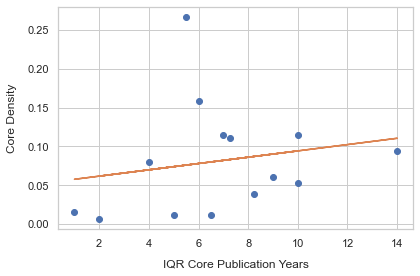

In [15]:
# iqr core publication years - core density
x = df['IQR Core Publication Years']
y = df['Core Density']
plt.plot(x, y, 'o')
plt.xlabel("IQR Core Publication Years", labelpad=10)
plt.ylabel("Core Density", labelpad=10)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.tight_layout()
plt.savefig('correlation/3.pdf')
spearmanr(x, y)

SpearmanrResult(correlation=0.09050794679584488, pvalue=0.7583045160290135)

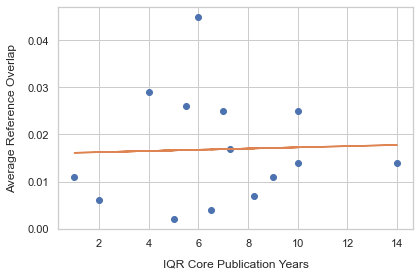

In [17]:
# iqr core publication years - average citation overlap 
x = df['IQR Core Publication Years']
y = df['Average Citation Overlap']
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.xlabel("IQR Core Publication Years", labelpad=10)
plt.ylabel("Average Reference Overlap", labelpad=10)
plt.plot(x, m*x + b)
plt.tight_layout()
plt.savefig('correlation/4.pdf')
spearmanr(x,y)

SpearmanrResult(correlation=-0.008800885413611155, pvalue=0.9761788034099909)

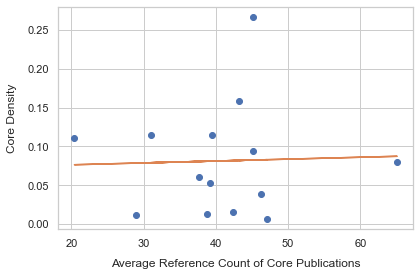

In [18]:
# average core publication references - core density
x = df['Average Core Publication References']
y = df['Core Density']
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.xlabel("Average Reference Count of Core Publications", labelpad=10)
plt.ylabel("Core Density", labelpad=10)
plt.plot(x, m*x + b)
plt.tight_layout()
plt.savefig('correlation/5.pdf')
spearmanr(x,y)

In [20]:
# correlation matrices of all independend variables in the thesis, 
# the according values were extracted manually from these lists
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

#correlation_matrix = df.corr(method='spearman')
correlation_matrix = df.corr(method=lambda x, y: spearmanr(x, y)[0])
correlation_matrix_p_value = df.corr(method=lambda x, y: spearmanr(x, y)[1])

correlation_list = correlation_matrix.unstack()
correlation_list_p = correlation_matrix_p_value.unstack()

# IQR Publication Years
publication_year_deviation_correlation = correlation_list.loc['IQR Core Publication Years']
publication_year_deviation_correlation_frame = publication_year_deviation_correlation.to_frame(name="R")

# IQR Publication Years p
publication_year_deviation_correlation_p = correlation_list_p.loc['IQR Core Publication Years']
publication_year_deviation_correlation_frame_p = publication_year_deviation_correlation_p.to_frame(name="p-value")

publication_year_deviation_correlation_frame_combined = pd.concat([publication_year_deviation_correlation_frame, publication_year_deviation_correlation_frame_p], axis=1)
publication_year_deviation_correlation_frame_combined = publication_year_deviation_correlation_frame_combined.reindex(publication_year_deviation_correlation_frame_combined["p-value"].abs().sort_values().index)

# x̃ References
core_node_reference_correlation = correlation_list.loc['Average Core Publication References']
core_node_reference_correlation_frame = core_node_reference_correlation.to_frame(name="R")

# x̃ References p
core_node_reference_correlation_p = correlation_list_p.loc['Average Core Publication References']
core_node_reference_correlation_frame_p = core_node_reference_correlation_p.to_frame(name="p-value")

core_node_reference_correlation_frame_combined = pd.concat([core_node_reference_correlation_frame, core_node_reference_correlation_frame_p], axis=1)
core_node_reference_correlation_frame_combined = core_node_reference_correlation_frame_combined.reindex(core_node_reference_correlation_frame_combined["p-value"].abs().sort_values().index)

print(publication_year_deviation_correlation_frame_combined.to_latex(index=True))  
print(core_node_reference_correlation_frame_combined.to_latex(index=True))

\begin{tabular}{lrr}
\toprule
{} &         R &   p-value \\
\midrule
BC Nodes                            &  0.418502 &  0.136418 \\
Core Publications                   &  0.409241 &  0.146217 \\
Skewness Years                      &  0.393840 &  0.163526 \\
Average Core Publication References & -0.363436 &  0.201498 \\
Core Density                        &  0.299230 &  0.298670 \\
DC Modularity                       & -0.294830 &  0.306176 \\
DC Clusters                         & -0.154526 &  0.597872 \\
Average Citation Overlap            &  0.090508 &  0.758305 \\
BC Modularity                       & -0.081408 &  0.782040 \\
Unconnected Core Publications       & -0.050514 &  0.863836 \\
DC Components                       & -0.050514 &  0.863836 \\
DC Nodes                            &  0.035204 &  0.904899 \\
BC Average Shortest Path            & -0.035204 &  0.904899 \\
BC Clusters                         & -0.033049 &  0.910698 \\
BC Density                          & -0.015402 &

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


Index(['Core Publications', 'IQR Core Publication Years',
       'Average Core Publication References', 'Average Citation Overlap',
       'Core Density', 'Unconnected Core Publications', 'DC Nodes',
       'DC Components', 'DC Modularity', 'DC Clusters', 'BC Nodes',
       'BC Density', 'BC Average Shortest Path', 'Skewness Years',
       'BC Modularity', 'BC Clusters'],
      dtype='object')
                                     Fisher-Pearson Coefficient
Core Publications                    0.342916                  
IQR Core Publication Years           0.218085                  
Average Core Publication References  0.308814                  
Average Citation Overlap             0.844235                  
Core Density                         1.196447                  
Unconnected Core Publications        1.545844                  
DC Nodes                            -0.254675                  
DC Components                        1.599792                  
DC Modularity              

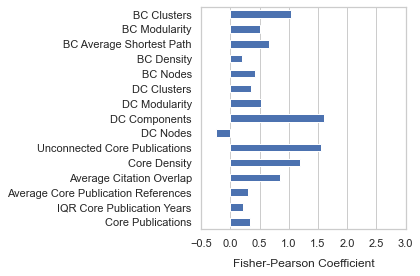

In [21]:
#skew values for all metrics in a barplot

print(df.columns)
df_metric_columns = np.append([df.columns[0:13]], df.columns[14:18])

df_skews_metrics = pd.DataFrame(columns = ["Fisher-Pearson Coefficient"])
for column in df_metric_columns:
    df_skews_metrics.loc[column] = skew(df[column].values)

axes_skew = df_skews_metrics.plot.barh(y="Fisher-Pearson Coefficient", legend=None)
axes_skew.grid(axis="y")
plt.tight_layout()
plt.savefig('skew_diagrams/metrics_skew.pdf')
plt.xticks(np.arange(-0.5, 3+0.5, 0.5))
plt.tight_layout()
plt.savefig('skew_diagrams/metrics_skew.pdf')

plt.xlabel("Fisher-Pearson Coefficient", labelpad=10)

plt.tight_layout()
plt.savefig('skew_diagrams/metrics_skew.pdf')

print(df_skews_metrics)